In [1]:
# %%
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from matplotlib.animation import FuncAnimation

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# %%
# Create output directory
output_dir = os.path.join(os.getcwd(), "woSubstrateOptim")
os.makedirs(output_dir, exist_ok=True)

In [3]:
# %%
# Function to export tensor to CSV using NumPy
def export_tensor_to_csv_numpy(tensor, filename):
    array = tensor.detach().cpu().numpy()

    # Ensure the array is of floating-point type
    if not np.issubdtype(array.dtype, np.floating):
        array = array.astype(np.float64)
    
    # Save with double precision and '.' as decimal delimiter
    np.savetxt(filename, array, delimiter=',', fmt='%.15f')
    print(f"Exported tensor to {filename} using NumPy with double precision.")



In [4]:
# %%
# Hyperparameters
grid_size = 245  # Adjusted to match MATLAB's gridSize
total_iterations = 100000  # Adjusted to match MATLAB's totalIterations
substrate_val = 0.999  # belongs to (0,1]
depth = 2
alpha_mat = torch.zeros((grid_size, grid_size), device=device)

# Reaction-Diffusion parameters
pa = 0.76
pb = 0.615
pe = 4.39
d = 500
dt = 1e-5
threshold = 1
gamma = 625
ph = 1
alpha = 1
amax = 30 # activator limiter 20
smax = 1e6 # suppressor limiter 40
rnd_init = 0.25
rnd_subs = 0.15

# Laplacian weights
lap = 6.8/13.6
lap_side = 1/13.6
lap_diag = .7/13.6 

In [5]:
# %%
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2

n = torch.linspace(1, substrate_val, grid_size, device=device)
n = n.repeat(grid_size, 1)
#n = torch.min(n * (1 - rnd_subs + torch.rand((grid_size, grid_size), device=device) * rnd_subs * 2), torch.ones_like(n))

n_init = n.clone()

print(mid)

print(n.shape)
print(u.shape)
print(v.shape)
print(c.shape)

n = torch.tensor(n, dtype=torch.float32, device=device)

122
torch.Size([245, 245])
torch.Size([245, 245])
torch.Size([245, 245])
torch.Size([245, 245])


C:\Users\georg\AppData\Local\Temp\ipykernel_5448\3696644040.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(n, dtype=torch.float32, device=device)


In [6]:
# %%
# Initial activator and suppressor states
cen_point = int(grid_size/2)
cen_span = 5
random_tensor = 0.2

for k in range(-cen_span, cen_span+1):
    for l in range(-cen_span, cen_span+1):
        if math.sqrt(k*k+l*l) <= cen_span:  # Check to ensure indices are within bounds
            c[cen_point+k, cen_point+l] = 0.8 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2)
            u[cen_point+k, cen_point+l] = 0.5 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2) 
            v[cen_point+k, cen_point+l] = 0.1 * (1 - random_tensor + torch.rand((1, 1), device=device) * random_tensor * 2) 

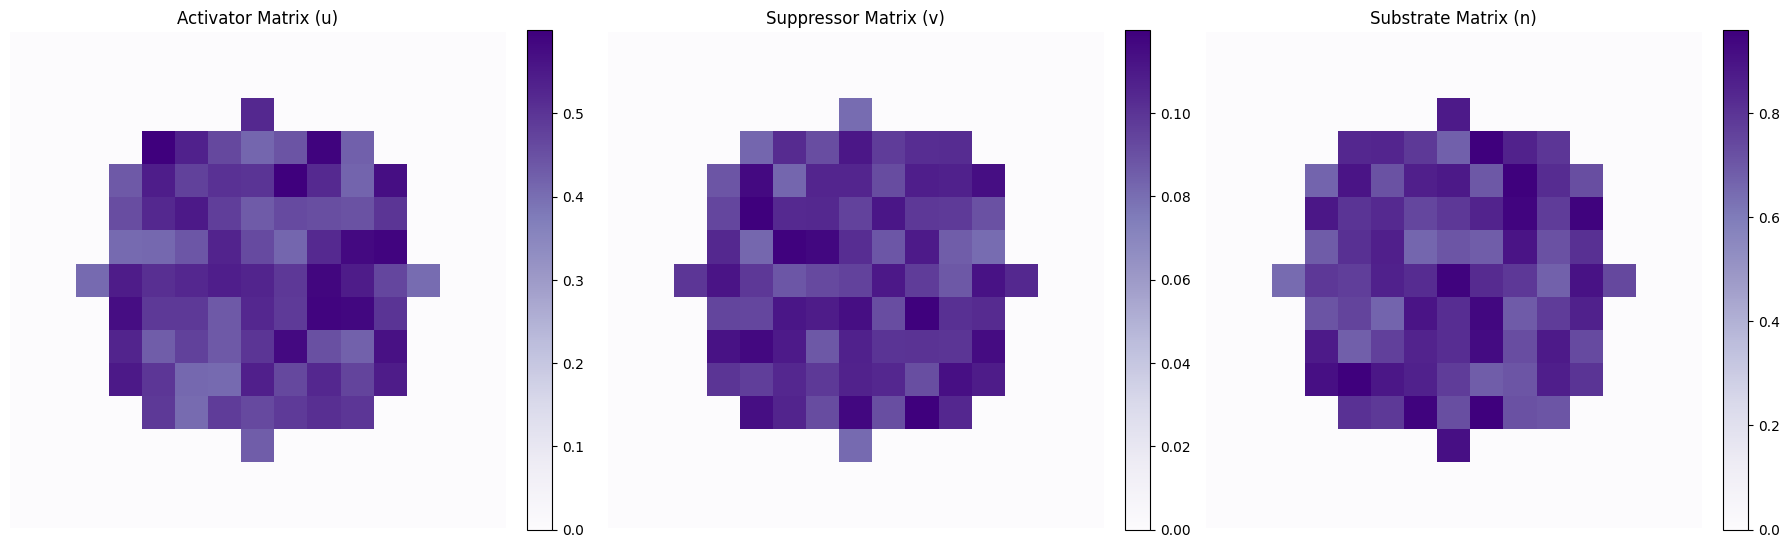

In [7]:
# %%
# Assuming 'u', 'v', and 'c' are PyTorch tensors and have been processed appropriately.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Wider figure to accommodate colorbars

# Define limits for zooming into the center
x_limits = (mid-cen_span*1.5, mid+cen_span*1.5)
y_limits = (mid-cen_span*1.5, mid+cen_span*1.5)

# Plot u matrix
im_u = axs[0].imshow(u.cpu().numpy(), cmap='Purples')
axs[0].set_title('Activator Matrix (u)')
axs[0].axis('off')
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
fig.colorbar(im_u, ax=axs[0], fraction=0.046, pad=0.04)  # Add colorbar to the plot of u

# Plot v matrix
im_v = axs[1].imshow(v.cpu().numpy(), cmap='Purples')
axs[1].set_title('Suppressor Matrix (v)')
axs[1].axis('off')
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
fig.colorbar(im_v, ax=axs[1], fraction=0.046, pad=0.04)  # Add colorbar to the plot of v

# Plot c matrix
im_c = axs[2].imshow(c.cpu().numpy(), cmap='Purples')
axs[2].set_title('Substrate Matrix (n)')
axs[2].axis('off')
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
fig.colorbar(im_c, ax=axs[2], fraction=0.046, pad=0.04)  # Add colorbar to the plot of c

plt.tight_layout()
plt.show()

In [8]:
# %%
# Define filenames with step number
filename_c = os.path.join(output_dir, f'c_init.csv')
filename_u = os.path.join(output_dir, f'u_init.csv')
filename_v = os.path.join(output_dir, f'v_init.csv')
filename_n = os.path.join(output_dir, f'n_init.csv')

# Export tensors to CSV using NumPy
export_tensor_to_csv_numpy(c, filename_c)
export_tensor_to_csv_numpy(u, filename_u)
export_tensor_to_csv_numpy(v, filename_v)
export_tensor_to_csv_numpy(n, filename_n)

# %%
# Define Laplacian kernel for convolution
L = torch.tensor([
    [lap_diag, lap_side, lap_diag],
    [lap_side, -lap, lap_side],
    [lap_diag, lap_side, lap_diag]
], dtype=torch.float32, device=device)

# %%
def update_visualization(step, u, v, c, n):
    fig = plt.figure(figsize=(15, 15))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().numpy(), cmap='viridis', vmin=0, vmax=amax)
    ax1.set_title(f'Activator u at timestep {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().numpy(), cmap='viridis', vmin=0, vmax=smax)
    ax2.set_title(f'Suppressor v at timestep {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().numpy(), cmap='Purples', vmin=0, vmax=1)
    ax3.set_title(f'Mycelium at timestep {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().numpy(), cmap='ocean', vmin=0, vmax=1)
    ax4.set_title('Substrate')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_init.csv using NumPy with double precision.


In [9]:
# %%
# # Pre-calculate the Laplacian kernel indices and weights if they remain constant
lap_kernel = torch.zeros((2*depth+1, 2*depth+1), device=device)
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            lap_kernel[depth, depth] = lap
        elif abs(dx) == abs(dy):
            lap_kernel[depth + dx, depth + dy] = lap_diag
        else:
            lap_kernel[depth + dx, depth + dy] = lap_side

print(lap_kernel)
print(lap_kernel.shape)

repeat_factor = grid_size // 5
D = lap_kernel.repeat(repeat_factor, repeat_factor)


print(f"D shape: {D.shape}")  # Should be (grid_size, grid_size)

tensor([[0.0515, 0.0735, 0.0735, 0.0735, 0.0515],
        [0.0735, 0.0515, 0.0735, 0.0515, 0.0735],
        [0.0735, 0.0735, 0.5000, 0.0735, 0.0735],
        [0.0735, 0.0515, 0.0735, 0.0515, 0.0735],
        [0.0515, 0.0735, 0.0735, 0.0735, 0.0515]], device='cuda:0')
torch.Size([5, 5])
D shape: torch.Size([245, 245])


In [10]:
# %%
# Define the 3x3 Laplacian kernel L
L = torch.tensor([
    [lap_diag, lap_side, lap_diag],
    [lap_side, -lap,     lap_side],
    [lap_diag, lap_side, lap_diag]
], dtype=torch.float32, device=device)

print(L)

tensor([[ 0.0515,  0.0735,  0.0515],
        [ 0.0735, -0.5000,  0.0735],
        [ 0.0515,  0.0735,  0.0515]], device='cuda:0')


In [11]:
# %%
import torch.nn.functional as F

def conv2_same(input_tensor, kernel):
    # Ensure the kernel has 4 dimensions
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, kH, kW]
    elif kernel.dim() == 4:
        pass  # Already in the correct shape
    else:
        raise ValueError("Kernel must be a 2D or 4D tensor.")
    
    # Extract kernel dimensions
    _, _, kH, kW = kernel.shape
    
    # Calculate padding for 'same' convolution
    pad_h = (kH - 1) // 2
    pad_w = (kW - 1) // 2
    
    # Reshape input to [N, C, H, W]
    input_reshaped = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # Perform convolution with calculated padding
    conv_result = F.conv2d(input_reshaped, kernel, padding=(pad_h, pad_w))
    
    # Reshape back to [H, W]
    return conv_result.squeeze(0).squeeze(0)

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_0.csv using NumPy with double precision.


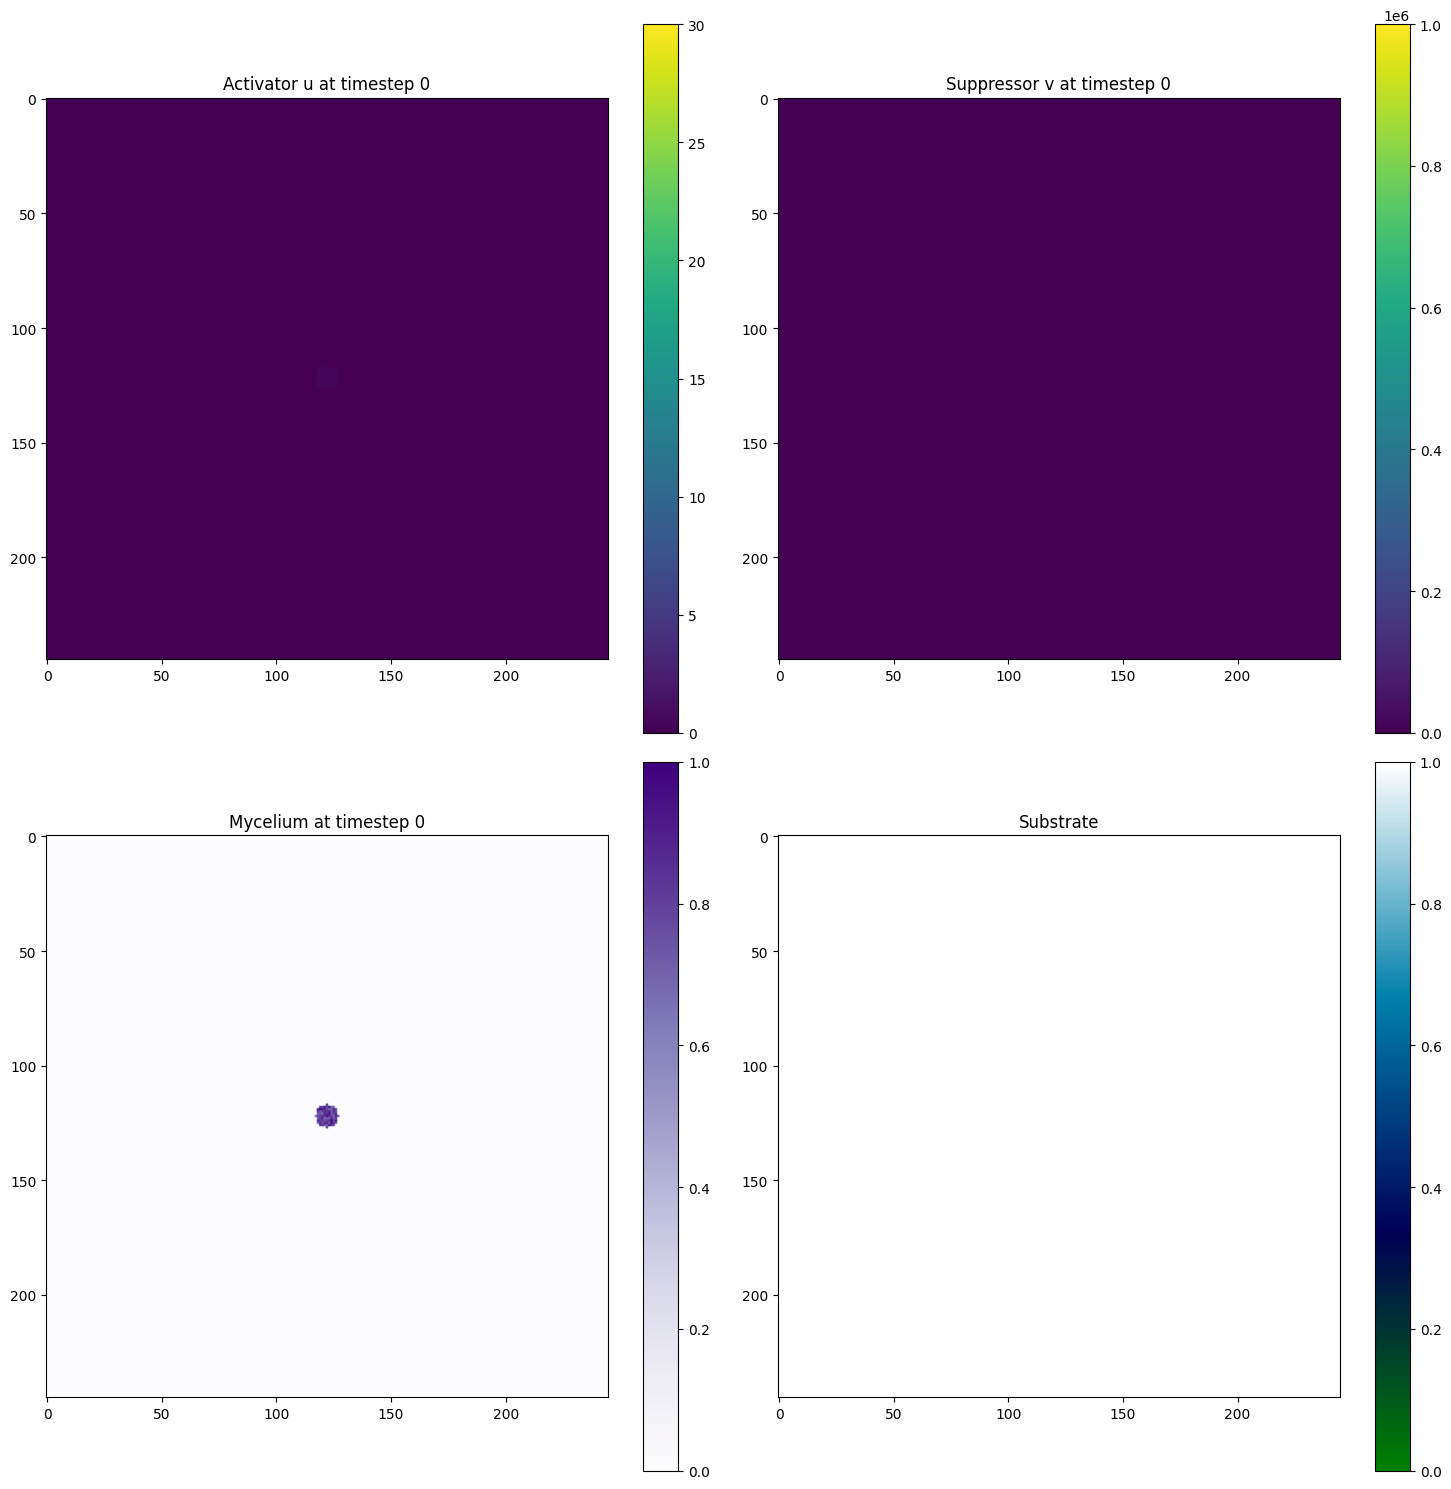

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_10000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_10000.csv using NumPy with double precision.


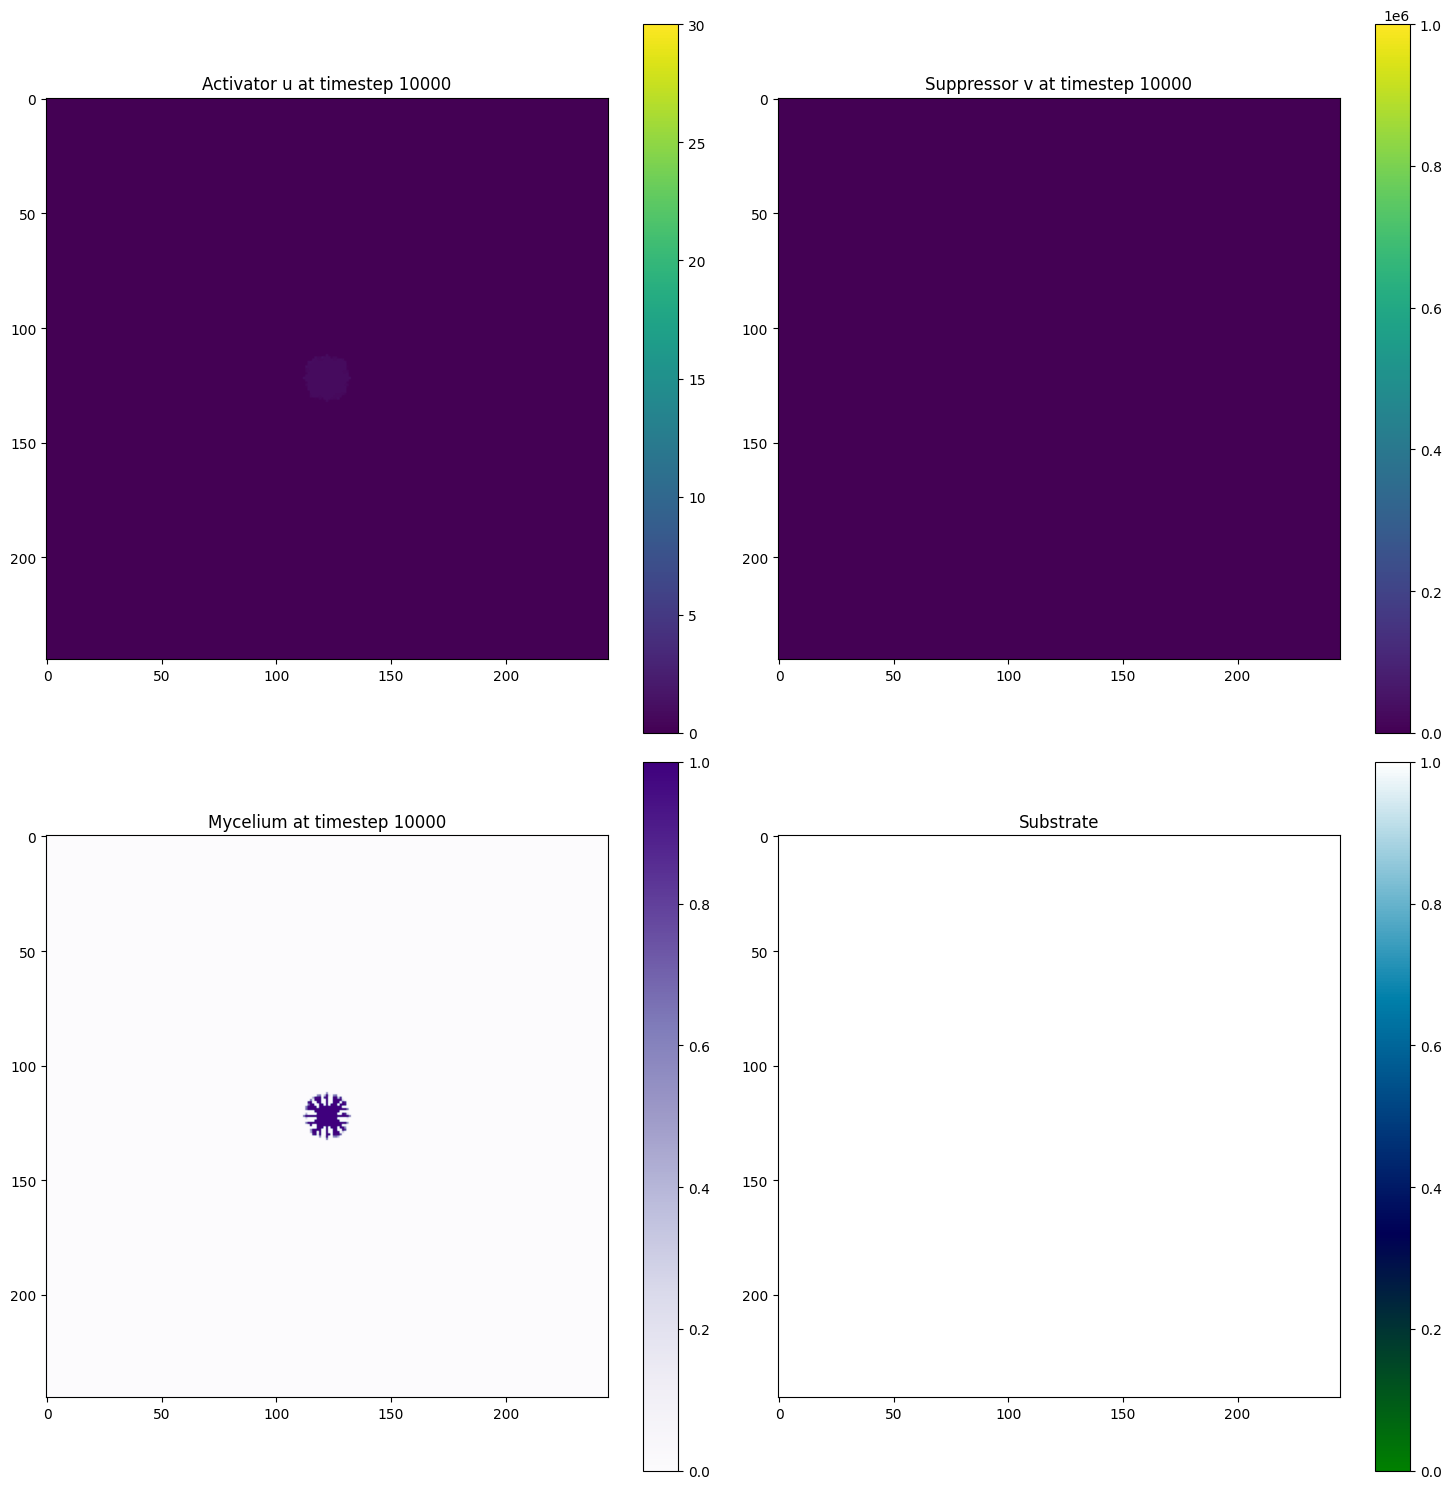

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_20000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_20000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_20000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_20000.csv using NumPy with double precision.


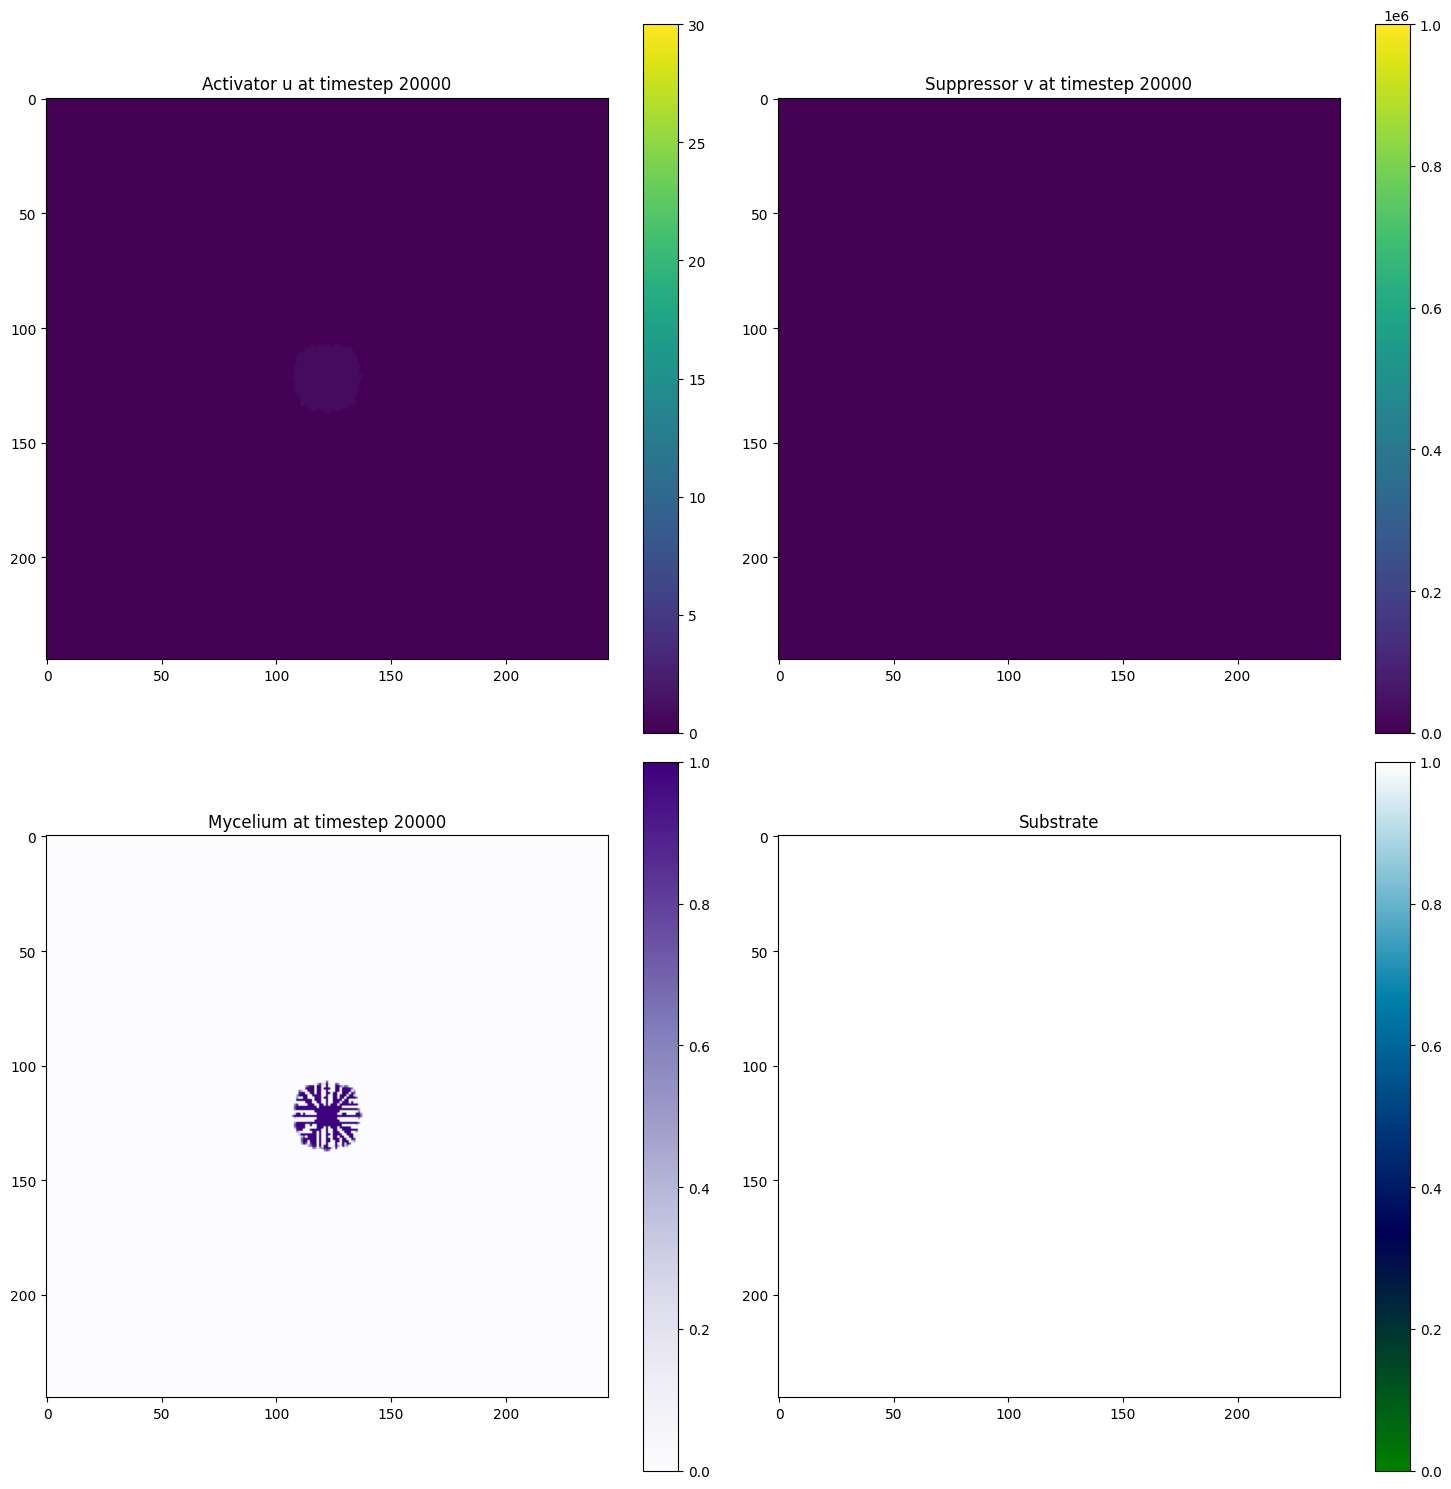

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_30000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_30000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_30000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_30000.csv using NumPy with double precision.


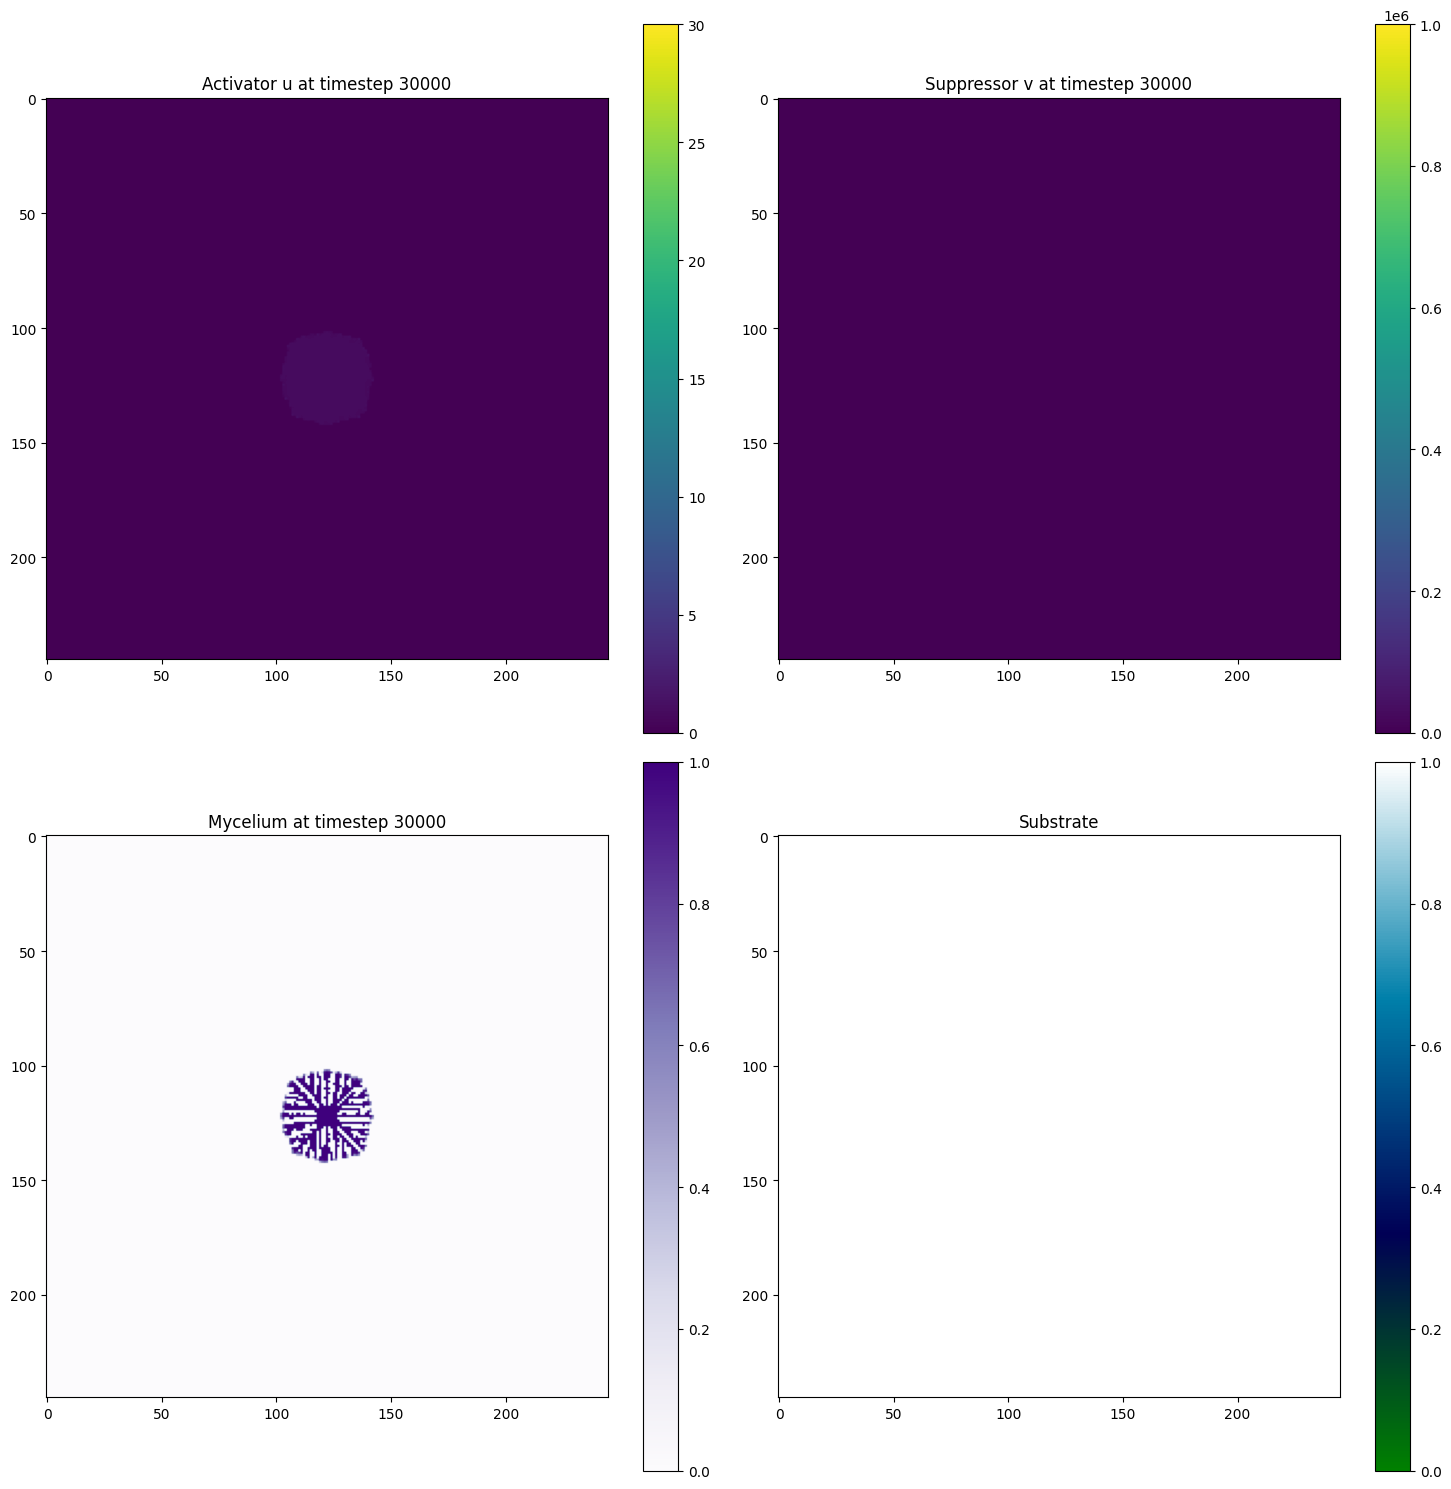

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_40000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_40000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_40000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_40000.csv using NumPy with double precision.


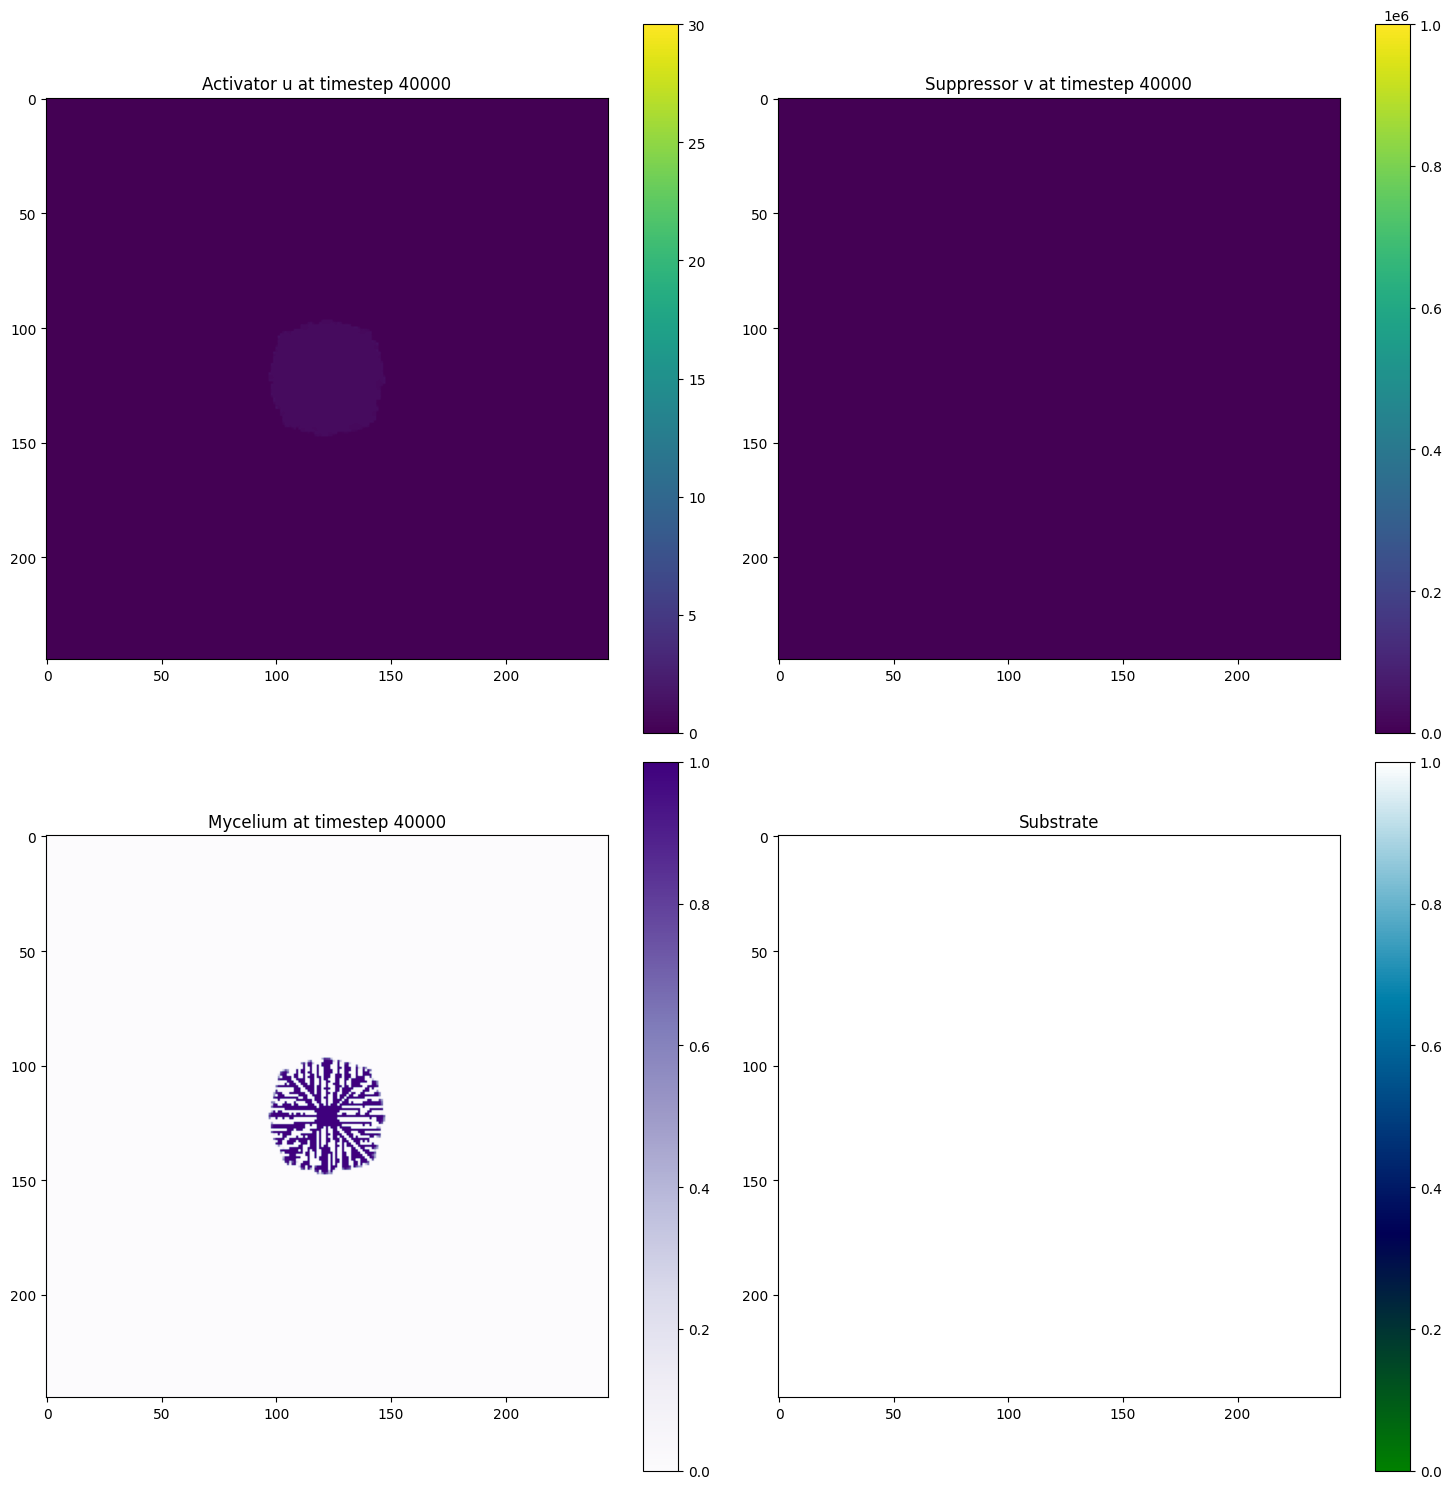

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_50000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_50000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_50000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_50000.csv using NumPy with double precision.


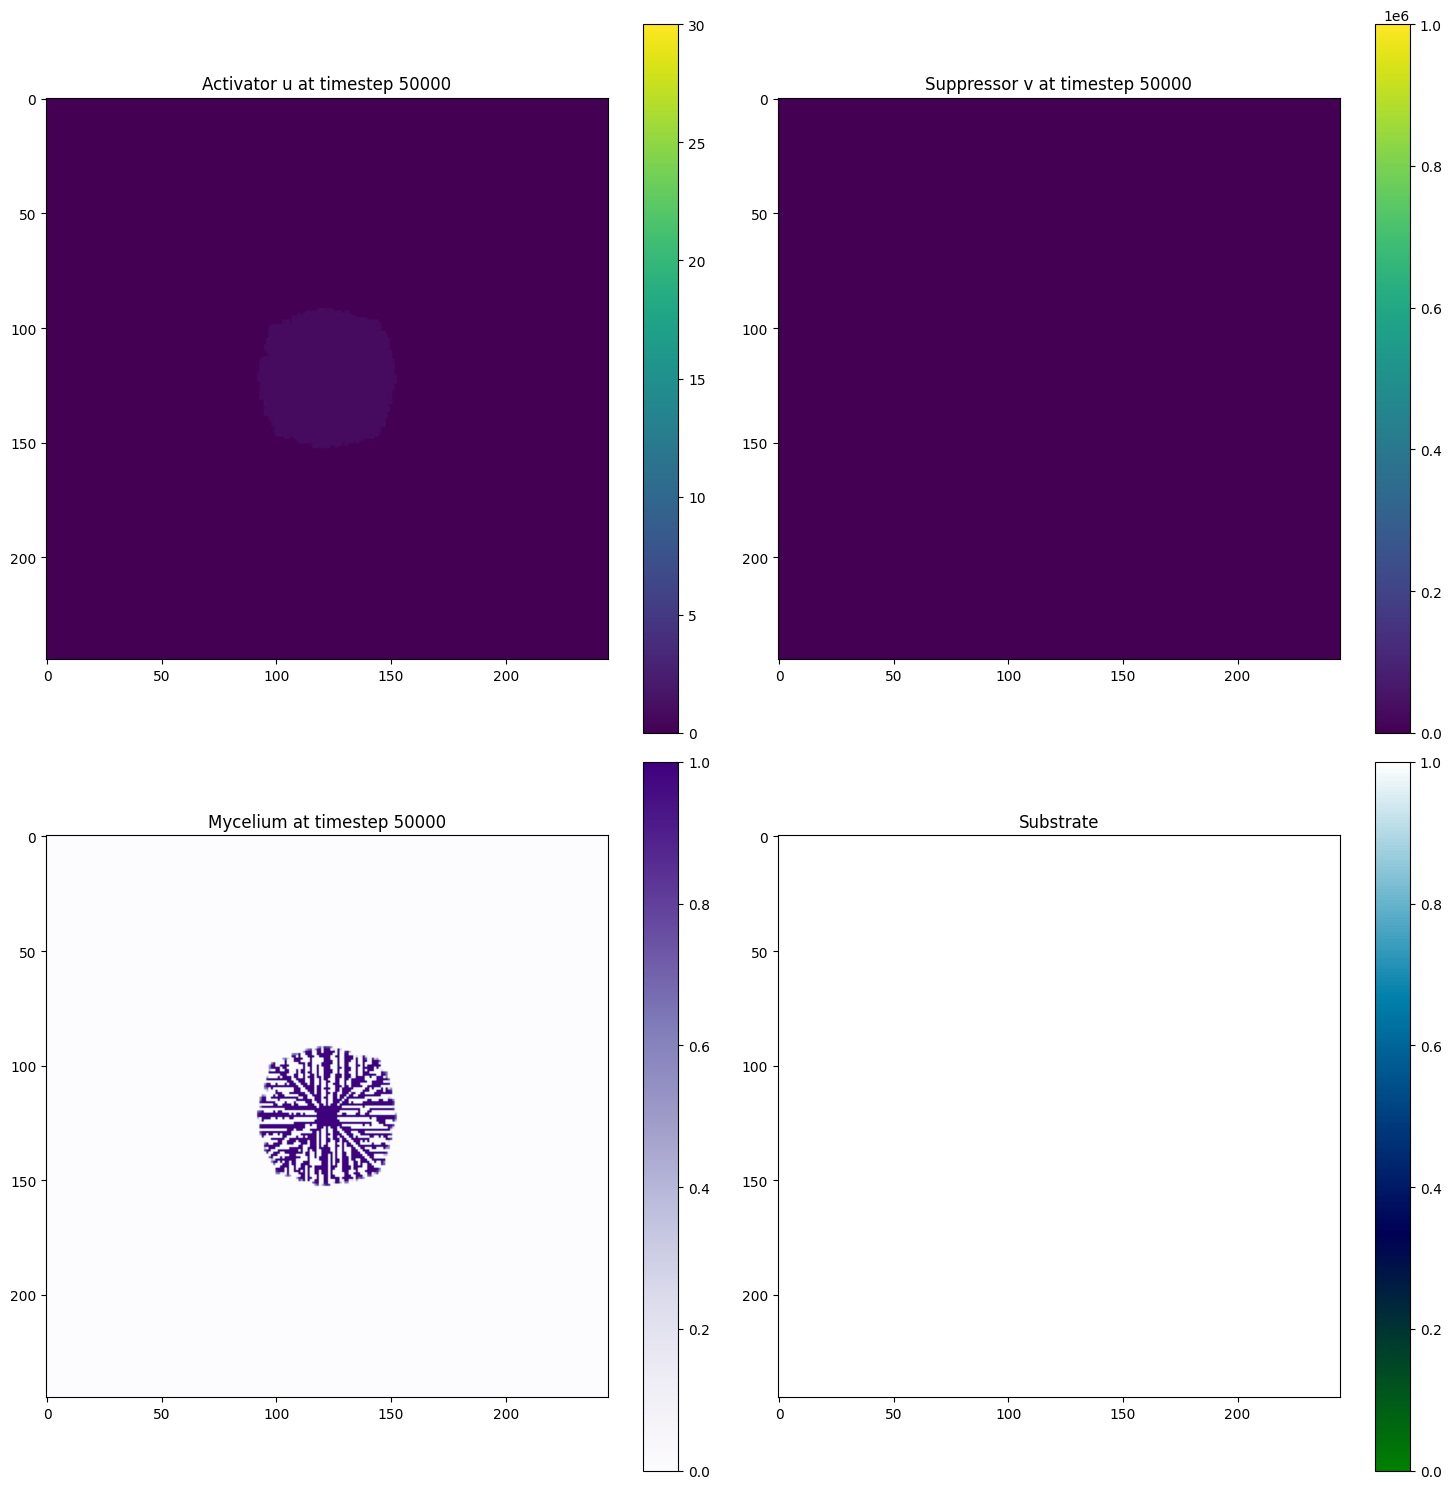

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_60000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_60000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_60000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_60000.csv using NumPy with double precision.


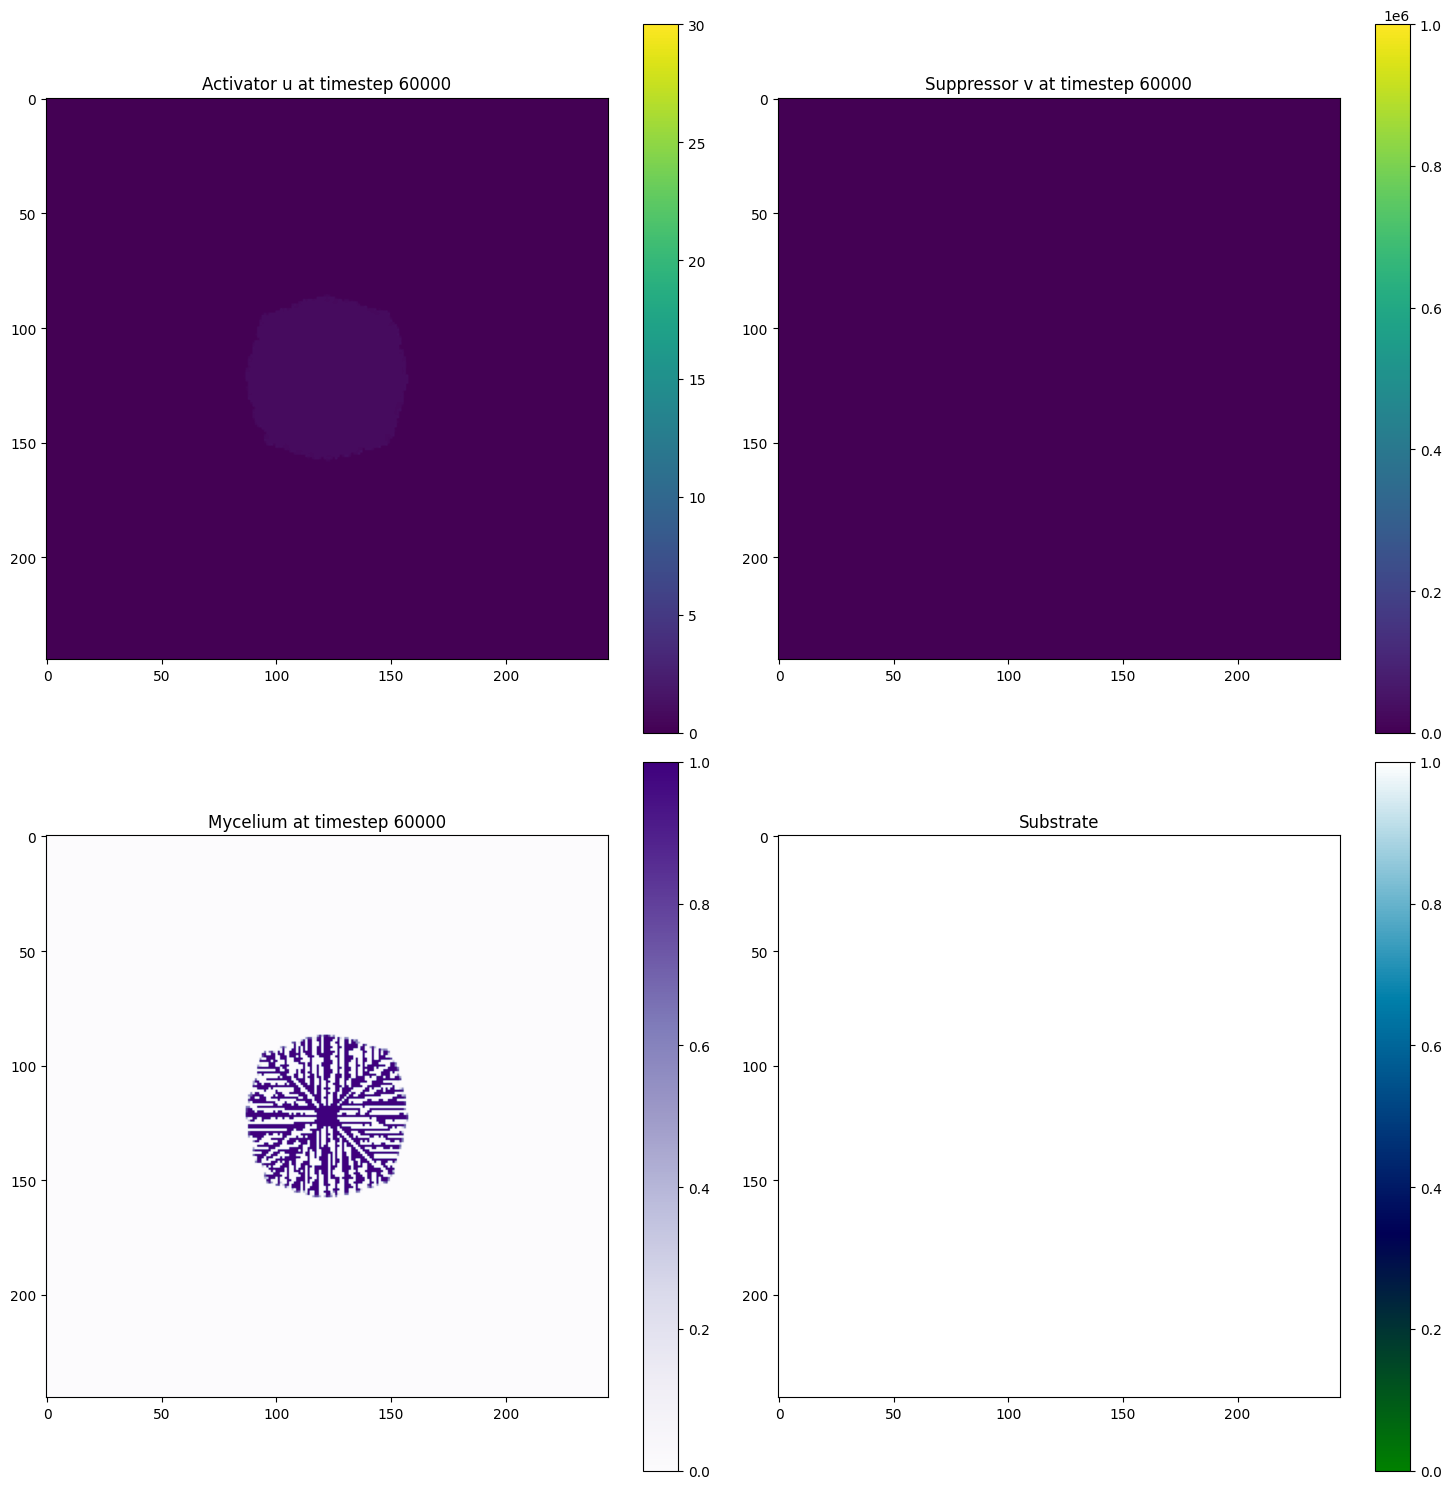

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_70000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_70000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_70000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_70000.csv using NumPy with double precision.


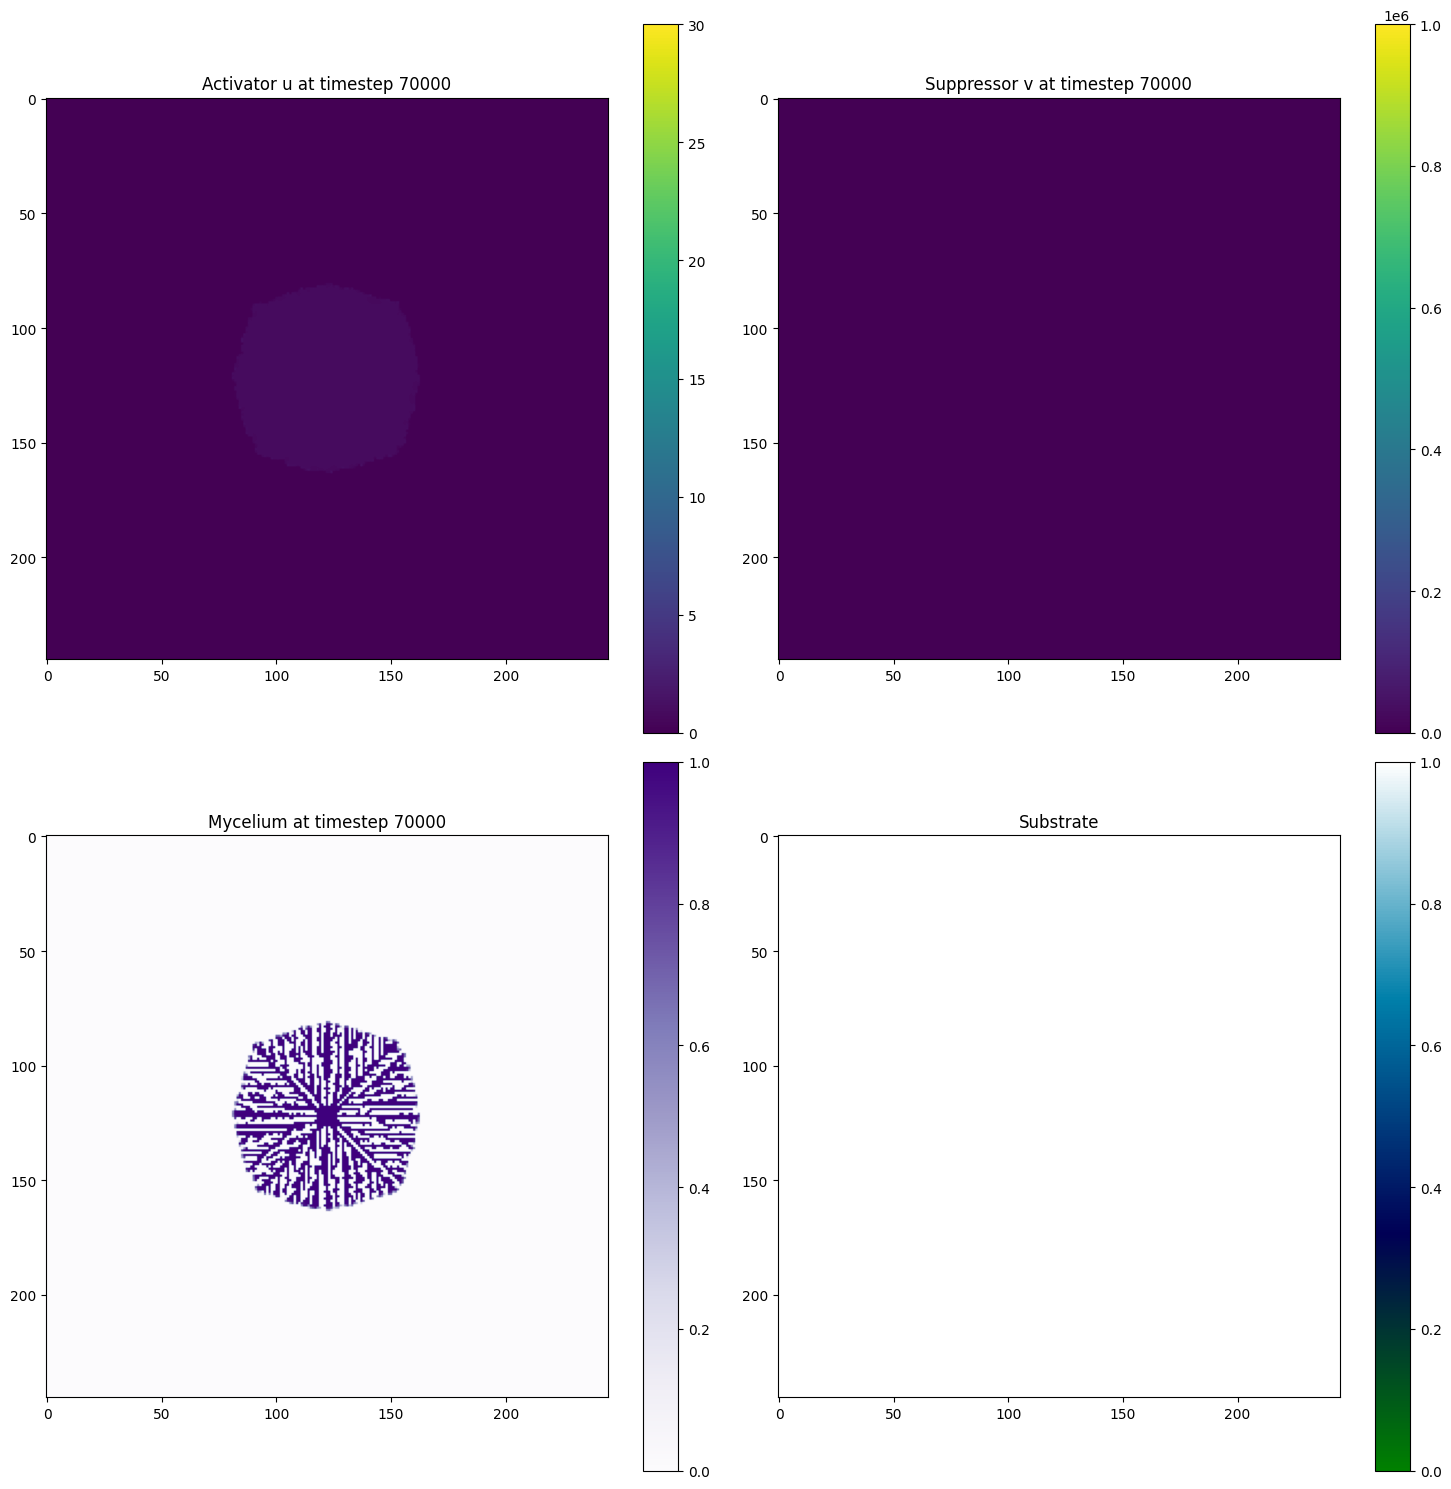

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_80000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_80000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_80000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_80000.csv using NumPy with double precision.


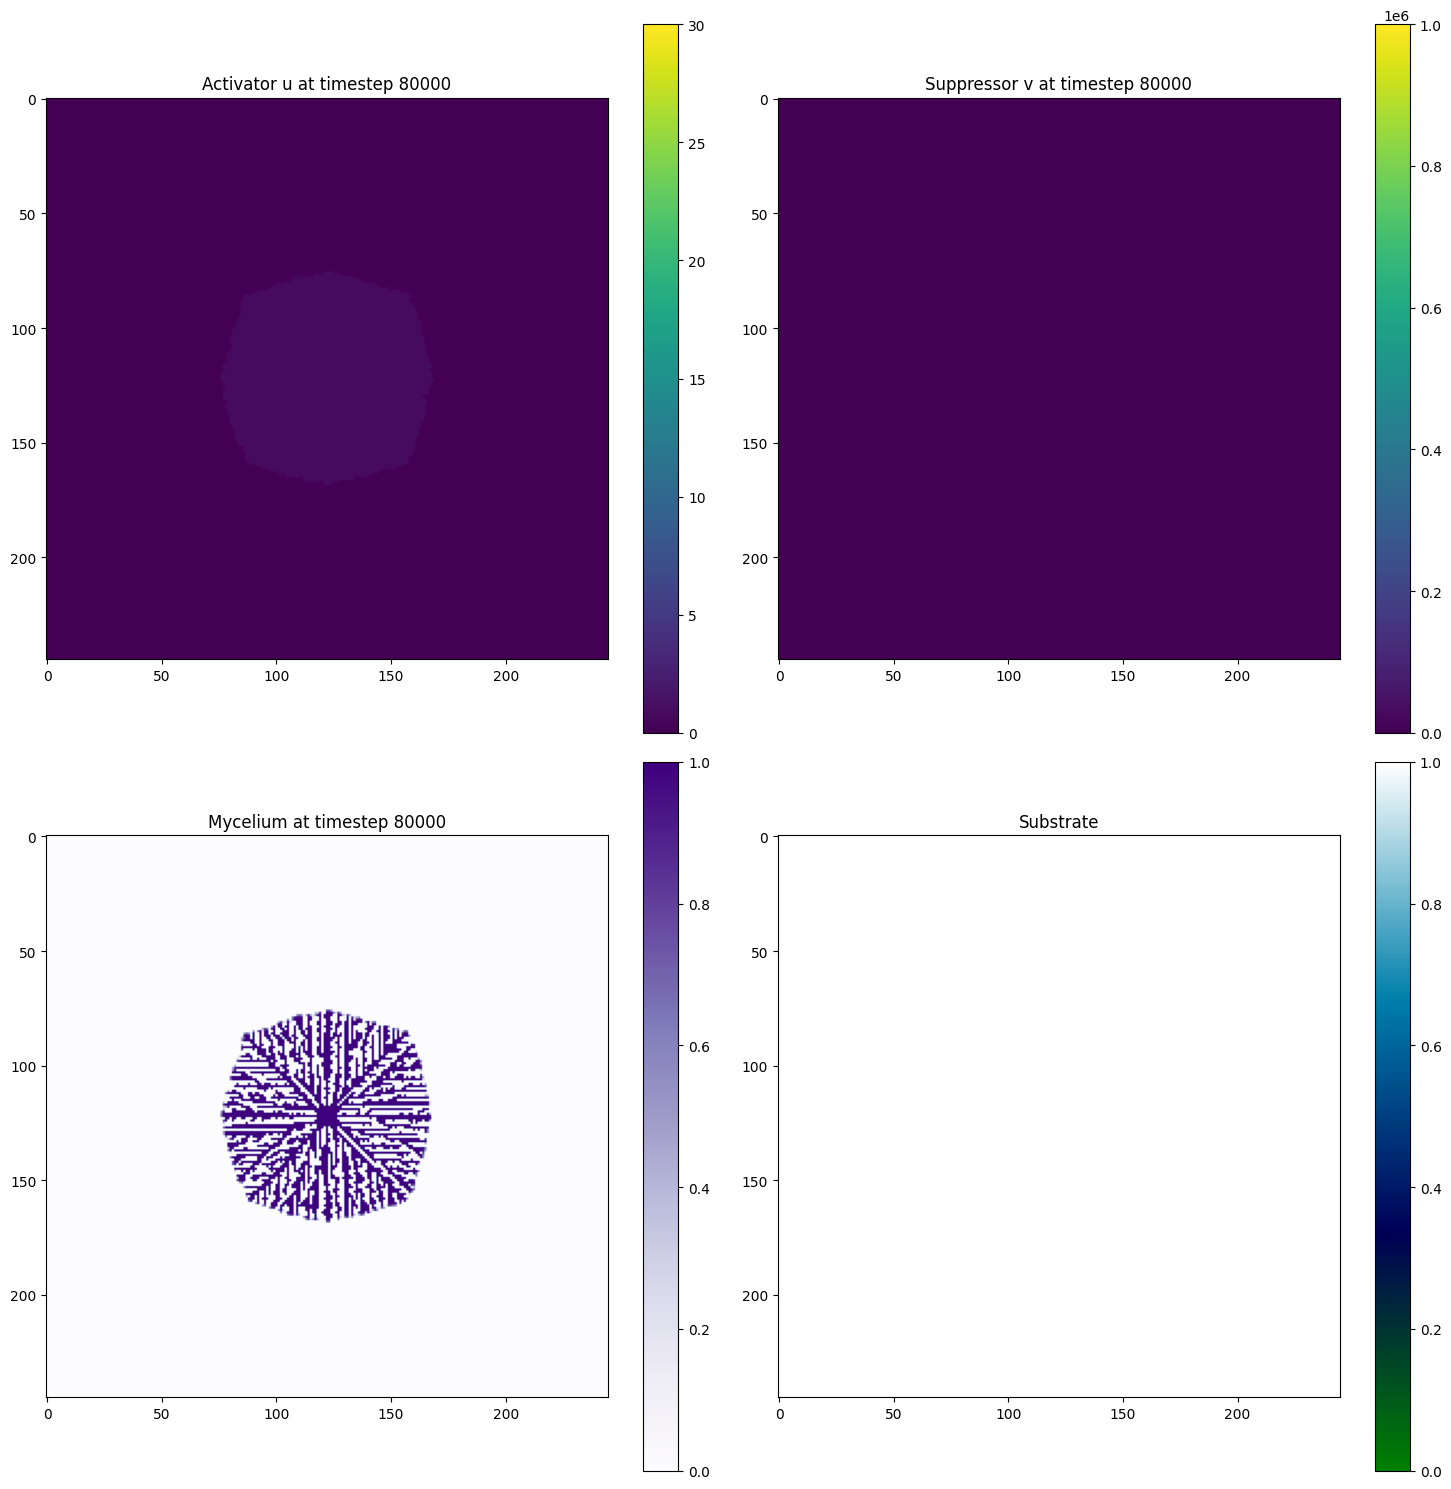

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_90000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_90000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_90000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_90000.csv using NumPy with double precision.


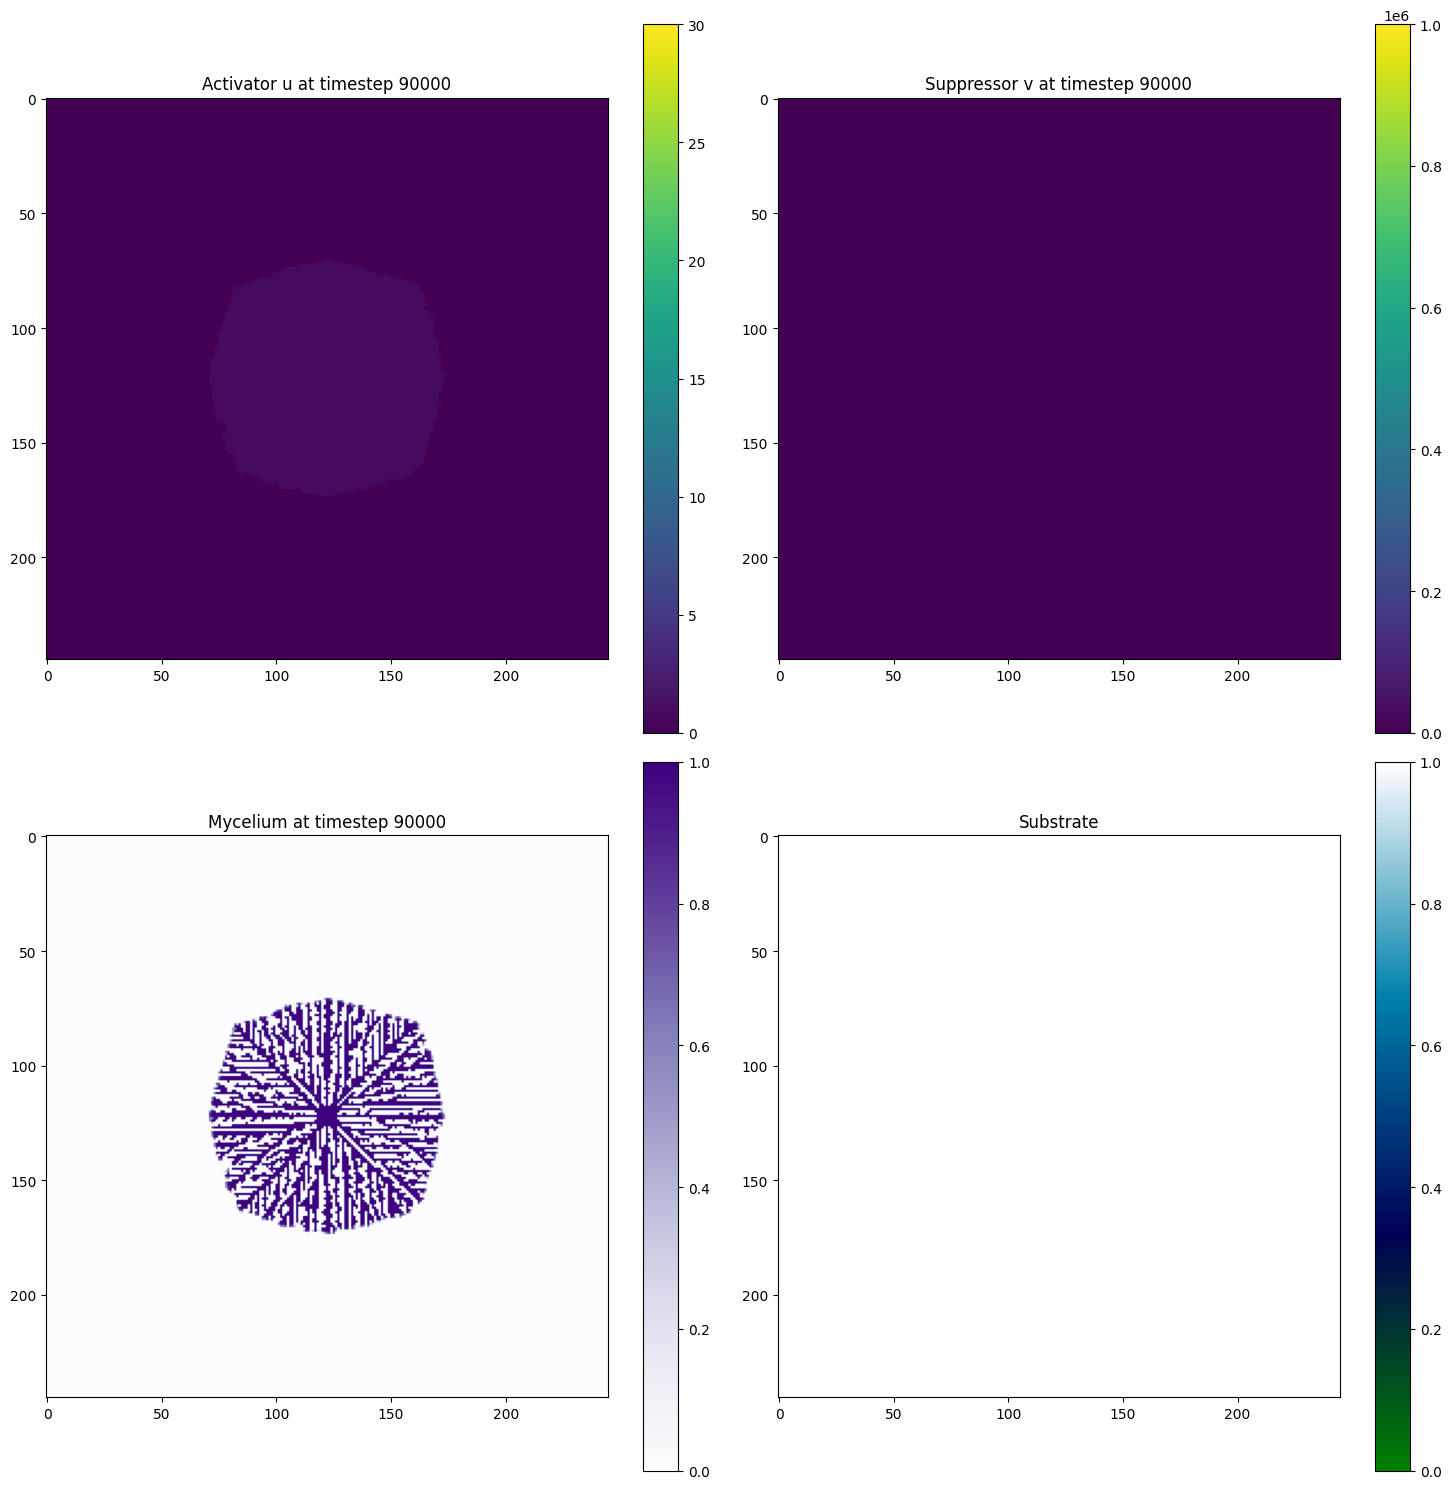

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\c_step_100000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\u_step_100000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\v_step_100000.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\woSubstrateOptim\n_step_100000.csv using NumPy with double precision.


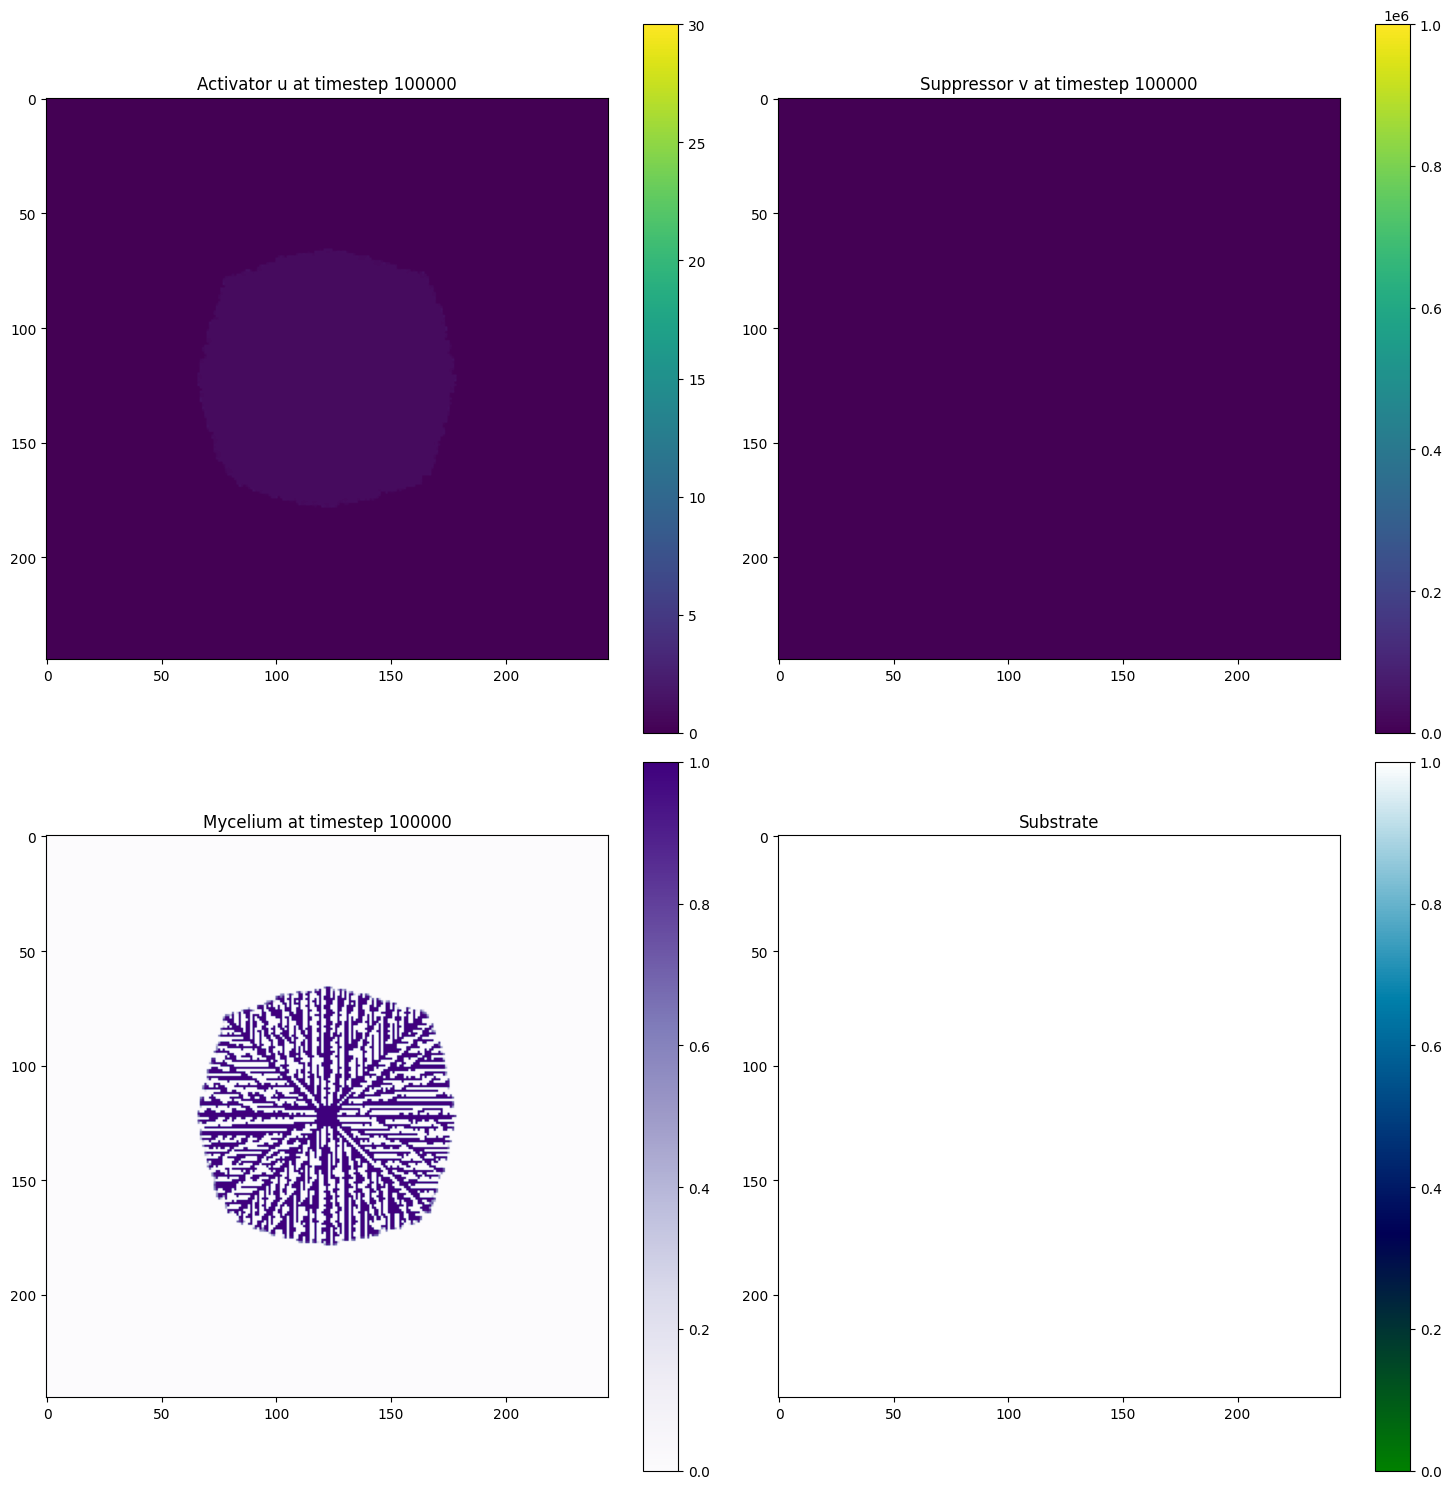

In [12]:
# %%
# Precompute the possible shifts and their corresponding weights based on depth
# Since depth is fixed, shifts and weights can be precomputed
shifts = []
weights = []
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            continue  # Skip the center
        distance = (dx**2 + dy**2) ** 0.5
        if distance <= 1:
            weight = 1.0
        else:
            weight = 1.0 / distance
        shifts.append((dx, dy))
        weights.append(weight)

# Convert weights to a tensor for vectorized operations
weights = torch.tensor(weights, dtype=torch.float32, device=device)

# Main simulation loop
for step in range(total_iterations+1):
    # # (Optional) Print progress at specific intervals
    # if step % 100 == 0:
    #     print(f"Step {step + 1}/{total_iterations} - Starting")

    # 1. Calculate Reaction Terms
    f_uv = (pa * u + u ** 2 - pb * u * v) * n
    g_uv = pe * u ** 3 - v

    # 2. Create a binary mask where c > 0.5
    c_positive = (c > 0.5).float()

    # 3. Initialize a list to store all shifted contributions
    shifted_contributions = []

    for idx, (dx, dy) in enumerate(shifts):
        weight = weights[idx]

        # Shift the c_positive mask
        if dx > 0:
            shifted = F.pad(c_positive, (0, 0, dx, 0))[:-dx, :]
        elif dx < 0:
            shifted = F.pad(c_positive, (0, 0, 0, -dx))[-dx:, :]
        else:
            shifted = c_positive.clone()

        if dy > 0:
            shifted = F.pad(shifted, (dy, 0, 0, 0))[:, :-dy]
        elif dy < 0:
            shifted = F.pad(shifted, (0, -dy, 0, 0))[:, -dy:]
        # else dy == 0: no padding needed

        # Multiply by the corresponding weight
        contribution = shifted * weight

        # Append to the list
        shifted_contributions.append(contribution)

    # 4. Stack all contributions and take the element-wise maximum
    if shifted_contributions:
        # Stack along a new dimension and compute max across that dimension
        stacked_contributions = torch.stack(shifted_contributions, dim=0)  # Shape: (num_shifts, H, W)
        ij_mat = torch.max(stacked_contributions, dim=0).values  # Shape: (H, W)
    else:
        ij_mat = torch.zeros_like(c_positive, device=device)

    # 5. For cells where distance <=1, set ij_mat to 1 where c >0.5
    # This ensures that cells with c > 0.5 have their ij_mat neighbors set correctly
    # According to MATLAB logic, cells within distance <=1 should be set to 1
    ij_mat = torch.where(c_positive == 1, torch.ones_like(ij_mat), ij_mat)

    # 6. Update ij_new based on neighbor conditions
    # Pad ij_mat to handle boundary conditions
    pad_ij = F.pad(ij_mat, (1, 1, 1, 1), mode='constant', value=0)

    # Extract immediate neighbors (up, down, left, right)
    neighbors_immediate = torch.stack([
        pad_ij[:-2, 1:-1],  # Up
        pad_ij[2:, 1:-1],   # Down
        pad_ij[1:-1, :-2],  # Left
        pad_ij[1:-1, 2:]    # Right
    ], dim=0)
    has_zero_immediate = (neighbors_immediate == 0).any(dim=0)

    # Extract diagonal neighbors (up-left, up-right, down-left, down-right)
    neighbors_diagonal = torch.stack([
        pad_ij[:-2, :-2],  # Up-Left
        pad_ij[:-2, 2:],   # Up-Right
        pad_ij[2:, :-2],   # Down-Left
        pad_ij[2:, 2:]     # Down-Right
    ], dim=0)
    has_zero_diagonal = (neighbors_diagonal == 0).any(dim=0)

    # Initialize ij_new as a clone of ij_mat
    ij_new = ij_mat.clone()

    # Apply conditions to update ij_new
    ij_new = torch.where(
        (ij_mat > 0) & has_zero_immediate,
        torch.zeros_like(ij_new),
        ij_new
    )
    ij_new = torch.where(
        (ij_mat > 0) & has_zero_diagonal,
        ij_mat / 2.0,
        ij_new
    )

    # 7. Compute Diffusion Using Convolution with Laplacian Kernel L
    conv_u = conv2_same(u, L)
    conv_v = conv2_same(v, L)

    # 8. Update Concentrations
    v_new = v + dt * (d * conv_v + gamma * g_uv)
    u_new = u + dt * (ij_new * (conv_u + gamma * f_uv))

    # 9. Apply Constraints Based on n
    u_new = torch.where(n == -1, torch.zeros_like(u_new), u_new)

    # 10. Compute alpha
    alpha = torch.where(
        u <= threshold,
        torch.tensor(0.49, device=device),
        0.49 - 2.5 * (u - threshold)
    )

    # 11. Update c_new
    c_new = c + dt * gamma * ph * c * (alpha - c) * (c - 1)

    # 12. Apply Random Noise Where alpha < 0
    noise_condition = (alpha < 0)
    random_noise = torch.rand_like(c) * rnd_subs / 10
    c_new = torch.where(noise_condition, c_new + random_noise, c_new)

    # 13. Ensure u_new and v_new Are Non-Negative and Clamp Values
    u_new = torch.clamp(u_new, min=0, max=amax)
    v_new = torch.clamp(v_new, min=0)
    c_new = torch.clamp(c_new, max=1)

    # 14. Check for NaNs or Infs
    if torch.isnan(u_new).any() or torch.isnan(v_new).any() or torch.isnan(c_new).any():
        print(f"NaN detected at step {step + 1}. Terminating simulation.")
        break
    if torch.isinf(u_new).any() or torch.isinf(v_new).any() or torch.isinf(c_new).any():
        print(f"Infinity detected at step {step + 1}. Terminating simulation.")
        break

    # 15. Update Variables for the Next Iteration
    u, v, c = u_new, v_new, c_new

    if step % 10000 == 0:

        # Define filenames with step number
        filename_c = os.path.join(output_dir, f'c_step_{step}.csv')
        filename_u = os.path.join(output_dir, f'u_step_{step}.csv')
        filename_v = os.path.join(output_dir, f'v_step_{step}.csv')
        filename_n = os.path.join(output_dir, f'n_step_{step}.csv')
        
        # Export tensors to CSV using NumPy
        export_tensor_to_csv_numpy(c, filename_c)
        export_tensor_to_csv_numpy(u, filename_u)
        export_tensor_to_csv_numpy(v, filename_v)
        export_tensor_to_csv_numpy(n, filename_n)

        update_visualization(step, u, v, c, n)

